# **Pengambilan Data**

In [78]:
import pandas as pd
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set path untuk data
BASE_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/KK/Code ginjal kronik/KNN/'
df_cdk = pd.read_csv(BASE_PATH + 'mentahan_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
df_cdk.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [80]:
df_cdk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

# **PreProcessing**

In [81]:
import pandas as pd

def attributeSel(path):
    data = pd.read_csv(path, dtype=str)

    # Lihat nama kolom asli untuk debugging
    print("Kolom asli:", data.columns.tolist())

    row_drop = [1, 2]
    data = data.drop(index=row_drop)

    # Hapus spasi/tab di nama kolom
    data.columns = data.columns.str.strip()

    # Pilih kolom yang dibutuhkan
    data = data[['age', 'bp', 'bgr', 'sc', 'bu', 'classification']]

    # Hapus baris/kolom kosong total
    data = data.dropna(how='all')
    data = data.dropna(axis=1, how='all')

    # Ubah kolom ke numerik
    for col in ['age', 'bp', 'bgr', 'sc', 'bu']:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Tangani missing value
    for i in data.columns:
        if data[i].isnull().any():
            if data[i].dtype in ['float64', 'int64']:
                data[i] = data[i].fillna(round(data[i].mean()))
            else:
                data[i] = data[i].fillna(data[i].mode()[0])
    return data

# Jalankan preprocessing
df = attributeSel(BASE_PATH + 'mentahan_data.csv')

# Bersihkan classification
df['classification'] = df['classification'].astype(str).str.strip().str.lower()
classification_mapping = {
    'ckd': 'ckd',
    'notckd': 'notckd',
    'not ckd': 'notckd',
    'no ckd': 'notckd'
}
df['classification'] = df['classification'].replace(classification_mapping)

# Simpan ke Google Drive (file asli)
df.to_csv(BASE_PATH + 'data1.csv', index=False)

Kolom asli: ['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


In [82]:
df = pd.read_csv(BASE_PATH + 'data1.csv')
df.head()

,age,bp,bgr,sc,bu,classification
0,48.0,80.0,121.0,1.2,36.0,ckd
1,48.0,70.0,117.0,3.8,56.0,ckd
2,51.0,80.0,106.0,1.4,26.0,ckd
3,60.0,90.0,74.0,1.1,25.0,ckd
4,68.0,70.0,100.0,24.0,54.0,ckd


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             398 non-null    float64
 1   bp              398 non-null    float64
 2   bgr             398 non-null    float64
 3   sc              398 non-null    float64
 4   bu              398 non-null    float64
 5   classification  398 non-null    object 
dtypes: float64(5), object(1)
memory usage: 18.8+ KB


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings('ignore')

# Load data (sesuaikan dengan path Anda)
df = pd.read_csv(BASE_PATH + 'data1.csv')

print("Data berhasil dimuat!")
print(f"Shape data: {df.shape}")
print("\nInfo data:")
df.head()

Data berhasil dimuat!
Shape data: (398, 6)

Info data:


,age,bp,bgr,sc,bu,classification
0,48.0,80.0,121.0,1.2,36.0,ckd
1,48.0,70.0,117.0,3.8,56.0,ckd
2,51.0,80.0,106.0,1.4,26.0,ckd
3,60.0,90.0,74.0,1.1,25.0,ckd
4,68.0,70.0,100.0,24.0,54.0,ckd


In [85]:
# Cek data dan missing values
print("Info dataset:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")

# Encode target variable
le = LabelEncoder()
df['classification'] = le.fit_transform(df['classification'])

print(f"\nDistribusi kelas:")
print(df['classification'].value_counts())

# Pisahkan features dan target
X = df.drop('classification', axis=1) # Fitur
y = df['classification'] # Target (ckd/notckd)

print(f"\nFeatures: {list(X.columns)}")
print(f"Shape X: {X.shape}, Shape y: {y.shape}")

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             398 non-null    float64
 1   bp              398 non-null    float64
 2   bgr             398 non-null    float64
 3   sc              398 non-null    float64
 4   bu              398 non-null    float64
 5   classification  398 non-null    object 
dtypes: float64(5), object(1)
memory usage: 18.8+ KB
None

Missing values:
age               0
bp                0
bgr               0
sc                0
bu                0
classification    0
dtype: int64

Distribusi kelas:
classification
0    248
1    150
Name: count, dtype: int64

Features: ['age', 'bp', 'bgr', 'sc', 'bu']
Shape X: (398, 5), Shape y: (398,)


# **Split Data Training dan Testing**

In [86]:
# Split data training dan testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data training: {X_train.shape}")
print(f"Data testing: {X_test.shape}")

print(f"\nDistribusi kelas training:")
print(pd.Series(y_train).value_counts())
print(f"\nDistribusi kelas testing:")
print(pd.Series(y_test).value_counts())

Data training: (318, 5)
Data testing: (80, 5)

Distribusi kelas training:
classification
0    198
1    120
Name: count, dtype: int64

Distribusi kelas testing:
classification
0    50
1    30
Name: count, dtype: int64


# **Feature Scaling**

In [87]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Shape X_train_scaled: {X_train_scaled.shape}")
print(f"Shape X_test_scaled: {X_test_scaled.shape}")

# Contoh perbandingan sebelum dan sesudah scaling
print(f"\nContoh data sebelum scaling (2 baris pertama):")
print(X_train.head(2))
print(f"\nContoh data sesudah scaling (2 baris pertama):")
print(pd.DataFrame(X_train_scaled[:2], columns=X_train.columns))

# Export data training (original)
X_train_with_target = X_train.copy()
X_train_with_target['classification'] = y_train
X_train_with_target.to_csv(BASE_PATH + 'data_training.csv', index=False)

# Export data testing (original)
X_test_with_target = X_test.copy()
X_test_with_target['classification'] = y_test
X_test_with_target.to_csv(BASE_PATH + 'data_testing.csv', index=False)

# 3. Export data training (scaled)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df['classification'] = y_train.values
X_train_scaled_df.to_csv(BASE_PATH + 'data_training_scaled.csv', index=False)

# 4. Export data testing (scaled)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled_df['classification'] = y_test.values
X_test_scaled_df.to_csv(BASE_PATH + 'data_testing_scaled.csv', index=False)

Shape X_train_scaled: (318, 5)
Shape X_test_scaled: (80, 5)

Contoh data sebelum scaling (2 baris pertama):
      age     bp    bgr   sc    bu
190  46.0  110.0  130.0  0.9  16.0
43   54.0   80.0  208.0  5.9  89.0

Contoh data sesudah scaling (2 baris pertama):
        age        bp       bgr        sc        bu
0 -0.345127  2.383835 -0.250712 -0.355612 -0.855932
1  0.130498  0.234937  0.758811  0.484541  0.686487


# **Mencari Nilai K terbaik**

In [88]:
# Cari K terbaik
k_range = range(1, 21)
akurasi = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    akurasi.append(acc)

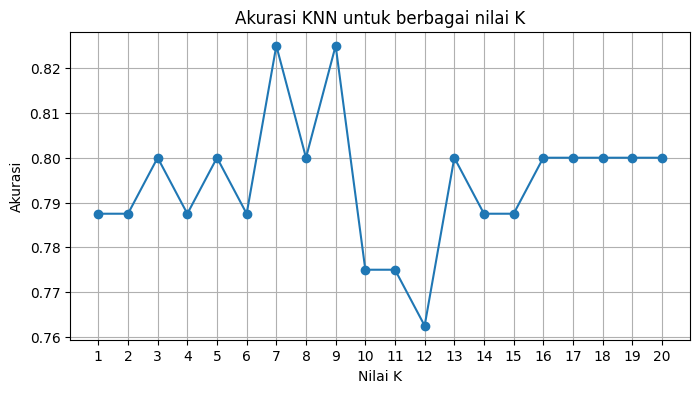

In [89]:
# Visualisasi akurasi tiap nilai K
plt.figure(figsize=(8,4))
plt.plot(k_range, akurasi, marker='o')
plt.title('Akurasi KNN untuk berbagai nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [90]:
# Tampilkan K terbaik
k_terbaik = k_range[akurasi.index(max(akurasi))]
print(f"Nilai K terbaik: {k_terbaik}, Akurasi: {max(akurasi)*100:.2f}%")

Nilai K terbaik: 7, Akurasi: 82.50%


# **Implementasi Manual Euclidean Distance**

In [91]:
# Implementasi manual Euclidean Distance
def euclidean_distance(point1, point2):
    """
    Menghitung jarak Euclidean antara dua titik
    Formula: √(Σ(xi - yi)²)
    """
    return np.sqrt(np.sum((point1 - point2) ** 2))

print("Implementasi Manual Euclidean Distance:")
print("="*45)

# Contoh perhitungan manual
sample1 = X_test_scaled[0]
sample2 = X_test_scaled[1]

distance_manual = euclidean_distance(sample1, sample2)

print(f"Sample 1: {sample1}")
print(f"Sample 2: {sample2}")
print(f"Euclidean Distance (Manual): {distance_manual:.4f}")

# Mengbandingkan dengan sklearn
distance_sklearn = euclidean_distances([sample1], [sample2])[0][0]
print(f"Euclidean Distance (Sklearn): {distance_sklearn:.4f}")
print(f"Hasil sama: {np.isclose(distance_manual, distance_sklearn)}")

Implementasi Manual Euclidean Distance:
Sample 1: [-0.76129892 -0.48136207 -0.32836775 -0.4060209  -0.72915747]
Sample 2: [-0.28567406 -0.48136207 -0.6519329  -0.13717208 -0.22206078]
Euclidean Distance (Manual): 0.8126
Euclidean Distance (Sklearn): 0.8126
Hasil sama: True


# **Training Model KNN**

In [92]:
# Membuat dan training model KNN dengan Euclidean distance
knn = KNeighborsClassifier(
    n_neighbors=7,
    metric='euclidean',
    weights='uniform'
)

print("Training model KNN...")
knn.fit(X_train_scaled, y_train)

# Prediksi
y_pred_knn = knn.predict(X_test_scaled)

print(f"Parameter model:")
print(f"- n_neighbors: {knn.n_neighbors}")
print(f"- metric: {knn.metric}")
print(f"- weights: {knn.weights}")

Training model KNN...
Parameter model:
- n_neighbors: 7
- metric: euclidean
- weights: uniform


# **Confusion Matrix**

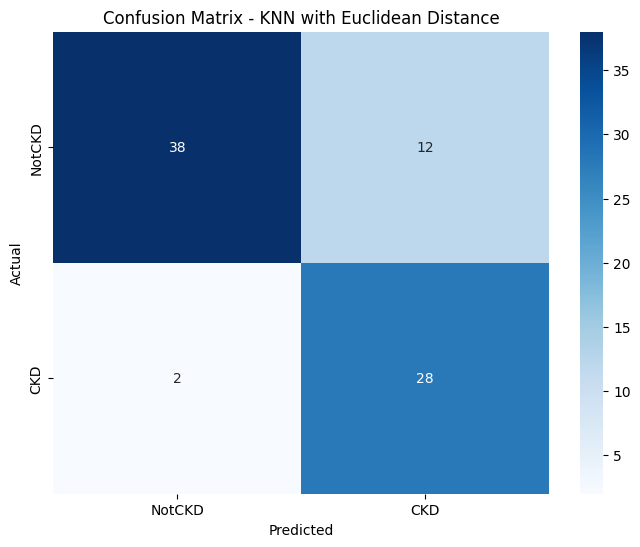

Confusion Matrix:
[[38 12]
 [ 2 28]]


In [93]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NotCKD', 'CKD'],
            yticklabels=['NotCKD', 'CKD'])
plt.title('Confusion Matrix - KNN with Euclidean Distance')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Confusion Matrix:")
print(cm)

# **Accuracy dan Classification Report**

In [94]:
# Menampilkan accuracy untuk KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Akurasi (KNN):", accuracy_knn)
print("")

accuracy_knn_percentage = accuracy_knn * 100
print("KNN Accuracy", "{:.2f}%".format(accuracy_knn_percentage))


print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

Akurasi (KNN): 0.825

KNN Accuracy 82.50%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84        50
           1       0.70      0.93      0.80        30

    accuracy                           0.82        80
   macro avg       0.82      0.85      0.82        80
weighted avg       0.86      0.82      0.83        80



# **Analisis Tetangga Terdekat**

In [95]:
# Contoh analisis tetangga terdekat untuk satu data test
print("Analisis Tetangga Terdekat:")
print("="*35)

index = 0 # indeks yang dianalisis

# Ambil satu sample test
test_sample = X_test_scaled[index]
actual_class = "CKD" if y_test.iloc[index] == 1 else "NotCKD"

# Cari 5 tetangga terdekat
distances, indices = knn.kneighbors([test_sample], n_neighbors=5)

print(f"Sample test - Kelas aktual: {actual_class}")
print(f"Prediksi: {'CKD' if y_pred_knn[index] == 1 else 'NotCKD'}")
print(f"\n5 Tetangga terdekat:")

for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    neighbor_class = "CKD" if y_train.iloc[idx] == 1 else "NotCKD"
    print(f"{i+1}. Jarak: {dist:.4f}, Kelas: {neighbor_class}")

Analisis Tetangga Terdekat:
Sample test - Kelas aktual: CKD
Prediksi: NotCKD

5 Tetangga terdekat:
1. Jarak: 0.0665, Kelas: NotCKD
2. Jarak: 0.3586, Kelas: CKD
3. Jarak: 0.3642, Kelas: NotCKD
4. Jarak: 0.3863, Kelas: CKD
5. Jarak: 0.4668, Kelas: NotCKD


# **Kesimpulan**

In [96]:
print("="*50)
print("           HASIL KLASIFIKASI KNN")
print("        dengan EUCLIDEAN DISTANCE")
print("="*50)

print(f"Dataset: Penyakit Ginjal Kronik")
print(f"Total data: {len(df)}")
print(f"Fitur: {len(X.columns)}")
print(f"Training: {len(X_train)} | Testing: {len(X_test)}")

print(f"\nModel KNN:")
print(f"- K (neighbors): {knn.n_neighbors}")
print(f"- Distance metric: Euclidean")
print(f"- Akurasi: {accuracy_knn_percentage:.2f}%")

print("="*50)

           HASIL KLASIFIKASI KNN
        dengan EUCLIDEAN DISTANCE
Dataset: Penyakit Ginjal Kronik
Total data: 398
Fitur: 5
Training: 318 | Testing: 80

Model KNN:
- K (neighbors): 7
- Distance metric: Euclidean
- Akurasi: 82.50%
